# Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
import os
import time
import random as python_random
from tqdm import tqdm
from collections import Counter
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

# Color

In [2]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

---

# Data Preperation

## Set Seed

In [3]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
python_random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## Load Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# 1. Definisikan path folder utama dan path file untuk setiap set data
base_load_path = '/content/drive/MyDrive/TUGAS AKHIR TA/DATA/Ahe-2_Final_Dataset'
train_file_path = os.path.join(base_load_path, 'Training', 'train_data.npz')
val_file_path = os.path.join(base_load_path, 'Validation', 'val_data.npz')
test_file_path = os.path.join(base_load_path, 'Testing', 'test_data.npz')


# 2. Memuat data latih
with np.load(train_file_path) as data:
    X_train = data['images']
    y_train = data['labels']
print(f"Data Latih berhasil dimuat dari: {train_file_path}")

# 3. Memuat data validasi
with np.load(val_file_path) as data:
    X_val = data['images']
    y_val = data['labels']
print(f"Data Validasi berhasil dimuat dari: {val_file_path}")

# 4. Memuat data uji
with np.load(test_file_path) as data:
    X_test = data['images']
    y_test = data['labels']
print(f"Data Uji berhasil dimuat dari: {test_file_path}")


# --- Verifikasi Data yang Berhasil Dimuat ---
print("\n--- Verifikasi Bentuk dan Tipe Data ---")
print(f"Bentuk X_train: {X_train.shape} | Tipe: {X_train.dtype}")
print(f"Bentuk y_train: {y_train.shape} | Tipe: {y_train.dtype}")
print("-" * 20)
print(f"Bentuk X_val:   {X_val.shape} | Tipe: {X_val.dtype}")
print(f"Bentuk y_val:   {y_val.shape} | Tipe: {y_val.dtype}")
print("-" * 20)
print(f"Bentuk X_test:  {X_test.shape} | Tipe: {X_test.dtype}")
print(f"Bentuk y_test:  {y_test.shape} | Tipe: {y_test.dtype}")
print("\nProses memuat data selesai! ✅")

Mounted at /content/drive
Data Latih berhasil dimuat dari: /content/drive/MyDrive/TUGAS AKHIR TA/DATA/Ahe-2_Final_Dataset/Training/train_data.npz
Data Validasi berhasil dimuat dari: /content/drive/MyDrive/TUGAS AKHIR TA/DATA/Ahe-2_Final_Dataset/Validation/val_data.npz
Data Uji berhasil dimuat dari: /content/drive/MyDrive/TUGAS AKHIR TA/DATA/Ahe-2_Final_Dataset/Testing/test_data.npz

--- Verifikasi Bentuk dan Tipe Data ---
Bentuk X_train: (8000, 224, 224, 3) | Tipe: uint8
Bentuk y_train: (8000,) | Tipe: <U10
--------------------
Bentuk X_val:   (1000, 224, 224, 3) | Tipe: uint8
Bentuk y_val:   (1000,) | Tipe: <U10
--------------------
Bentuk X_test:  (1000, 224, 224, 3) | Tipe: uint8
Bentuk y_test:  (1000,) | Tipe: <U10

Proses memuat data selesai! ✅


## One Hot Encoding

In [5]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# 1. Inisialisasi LabelEncoder
le = LabelEncoder()

# 2. Fit encoder pada data latih dan transformasikan (Belajar dari y_train)
# Ini mengubah label string menjadi angka (misal: 'glioma' -> 0, 'meningioma' -> 1, dst.)
y_train = le.fit_transform(y_train )

# 3. Gunakan encoder yang SAMA untuk mengubah data validasi dan uji
y_val = le.transform(y_val)
y_test = le.transform(y_test)

# --- Verifikasi hasil Label Encoding (Teks -> Angka) ---
print("\nPemetaan yang dipelajari oleh LabelEncoder:")
# Menampilkan kelas-kelas unik dan urutannya
for index, class_name in enumerate(le.classes_):
    print(f"- Angka {index}  -->  '{class_name}'")

# 4. Lakukan One-Hot Encoding pada semua data yang sudah menjadi angka
num_classes = len(le.classes_)
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Menampilkan bentuk akhir dari semua array
print("\nBentuk data final yang siap untuk training:")
print(f"X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}   | y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}  | y_test:  {y_test.shape}")

print("\nProses encoding selesai! ✅")


Pemetaan yang dipelajari oleh LabelEncoder:
- Angka 0  -->  'glioma'
- Angka 1  -->  'meningioma'
- Angka 2  -->  'notumor'
- Angka 3  -->  'pituitary'

Bentuk data final yang siap untuk training:
X_train: (8000, 224, 224, 3) | y_train: (8000, 4)
X_val:   (1000, 224, 224, 3)   | y_val:   (1000, 4)
X_test:  (1000, 224, 224, 3)  | y_test:  (1000, 4)

Proses encoding selesai! ✅


## Transfer Learning & Architecture Model

In [6]:
image_size = 224
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

model_output = effnet.output
model_output = tf.keras.layers.GlobalAveragePooling2D()(model_output)
model_output = tf.keras.layers.Dropout(rate=0.50)(model_output)
model_output = tf.keras.layers.BatchNormalization()(model_output)
model_output = tf.keras.layers.Dense(4, activation='softmax')(model_output)
model = tf.keras.models.Model(inputs=effnet.input, outputs=model_output)
model.summary()

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("model-ahe.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,059,815 (15.49 MB)

 Trainable params: 4,015,232 (15.32 MB)

 Non-trainable params: 44,583 (174.16 KB)

## Training The Model

In [7]:
start_time = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs= 12,
    batch_size= 64,
    callbacks=[
        tensorboard,
        checkpoint
        ]
)

end_time = time.time()
training_time = end_time - start_time
print(f"\nTotal Waktu Pelatihan: {training_time:.2f} detik ({training_time/60:.2f} menit)")

Epoch 1/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8062 - loss: 0.5576
Epoch 1: val_accuracy improved from -inf to 0.92600, saving model to model-ahe.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 122s 338ms/step - accuracy: 0.8068 - loss: 0.5560 - val_accuracy: 0.9260 - val_loss: 0.2517
Epoch 2/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9594 - loss: 0.1188
Epoch 2: val_accuracy did not improve from 0.92600
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 229ms/step - accuracy: 0.9594 - loss: 0.1187 - val_accuracy: 0.9190 - val_loss: 0.2357
Epoch 3/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9740 - loss: 0.0696
Epoch 3: val_accuracy did not improve from 0.92600
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 234ms/step - accuracy: 0.9741 - loss: 0.0695 - val_accuracy: 0.8800 - val_loss: 0.7706
Epoch 4/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9882 - loss: 0.0390
Epoch 4: val_accuracy did not improve from 0.92600
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 230ms/step - acc

# Prediction Accuracy

- Angka 0  -->  'glioma'
- Angka 1  -->  'meningioma'
- Angka 2  -->  'notumor'
- Angka 3  -->  'pituitary'

In [8]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
y_test_new = np.argmax(y_test, axis=1)

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
print("\n--- Laporan Klasifikasi ---")
print(classification_report(y_test_new, pred, target_names=labels))

32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 243ms/step

--- Laporan Klasifikasi ---
              precision    recall  f1-score   support

      glioma       0.94      1.00      0.97       250
  meningioma       1.00      0.88      0.94       250
     notumor       0.98      1.00      0.99       250
   pituitary       0.97      1.00      0.98       250

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



## Result

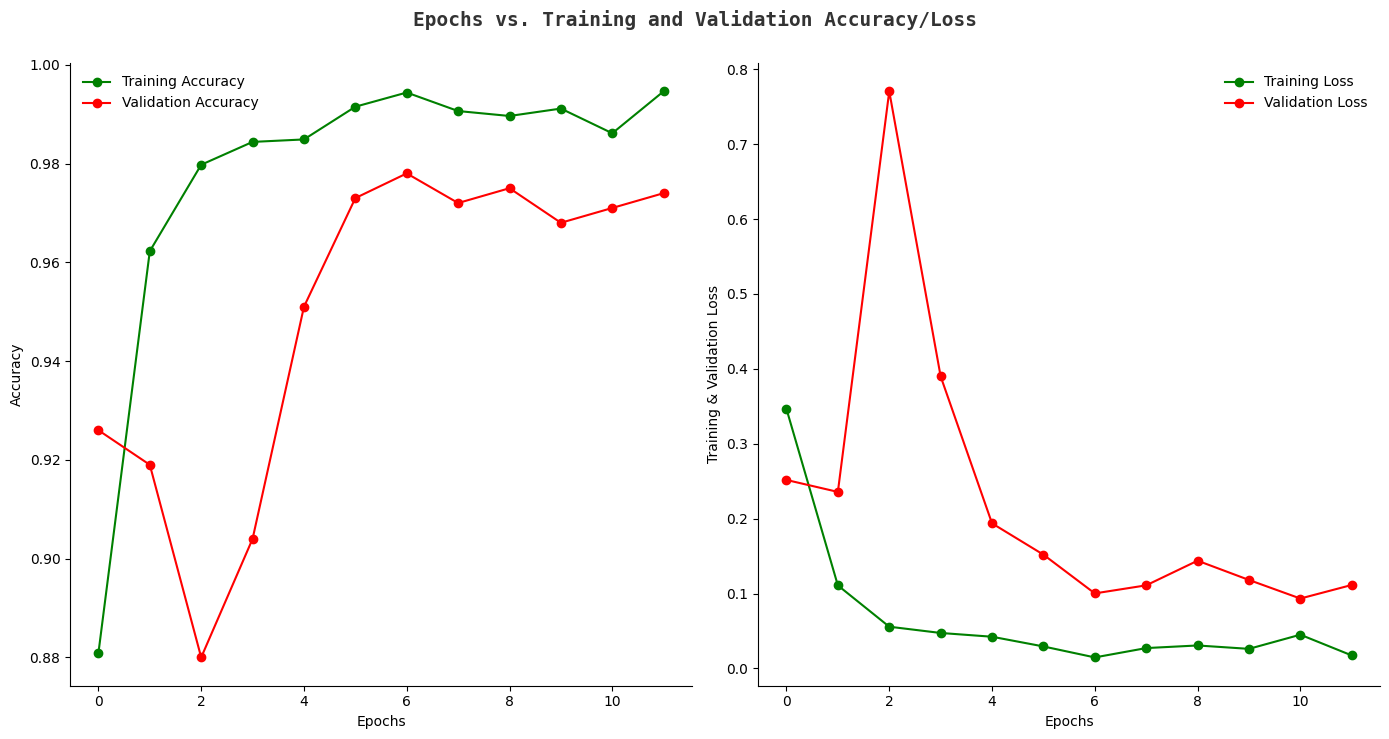

In [9]:
from warnings import filterwarnings

filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=14,fontweight='bold',
             fontname='monospace',color='black',y=1.02,x=0.5,alpha=0.8, ha='center', va='bottom')

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor='green',color='green',
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor='red',color='red',
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor='green',color='green',
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor='red',color='red',
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

plt.tight_layout()
fig.show()

In [10]:
# Melihat daftar akurasi dari data train dan data validasi dari setiap epoch
print("Accuracy:")
for epoch in range(len(history.history['accuracy'])):
  print(f"Epoch {epoch+1} : Training = {history.history['accuracy'][epoch]:.4f}, Validation = {history.history['val_accuracy'][epoch]:.4f}")

print("\nLoss:")
for epoch in range(len(history.history['loss'])):
  print(f"Epoch {epoch+1}: Training = {history.history['loss'][epoch]:.4f}, Validation = {history.history['val_loss'][epoch]:.4f}")

Accuracy:
Epoch 1 : Training = 0.8809, Validation = 0.9260
Epoch 2 : Training = 0.9622, Validation = 0.9190
Epoch 3 : Training = 0.9797, Validation = 0.8800
Epoch 4 : Training = 0.9844, Validation = 0.9040
Epoch 5 : Training = 0.9849, Validation = 0.9510
Epoch 6 : Training = 0.9915, Validation = 0.9730
Epoch 7 : Training = 0.9944, Validation = 0.9780
Epoch 8 : Training = 0.9906, Validation = 0.9720
Epoch 9 : Training = 0.9896, Validation = 0.9750
Epoch 10 : Training = 0.9911, Validation = 0.9680
Epoch 11 : Training = 0.9861, Validation = 0.9710
Epoch 12 : Training = 0.9946, Validation = 0.9740

Loss:
Epoch 1: Training = 0.3465, Validation = 0.2517
Epoch 2: Training = 0.1109, Validation = 0.2357
Epoch 3: Training = 0.0558, Validation = 0.7706
Epoch 4: Training = 0.0474, Validation = 0.3900
Epoch 5: Training = 0.0424, Validation = 0.1938
Epoch 6: Training = 0.0294, Validation = 0.1520
Epoch 7: Training = 0.0148, Validation = 0.1003
Epoch 8: Training = 0.0272, Validation = 0.1110
Epoch 9:

## Confussion Matrix & End WANDB Monitor

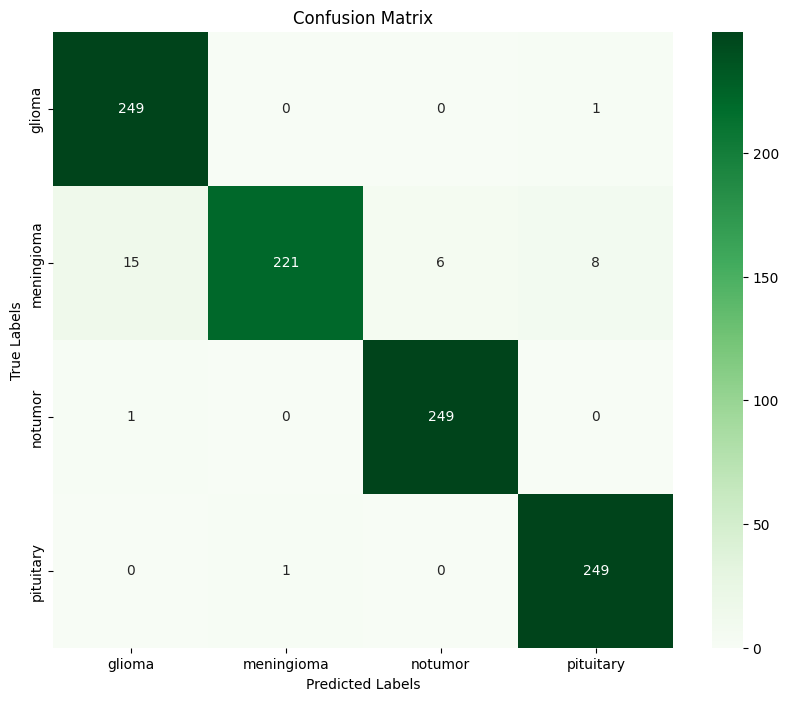

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_test_new, pred)
sns.heatmap(cm, ax=ax, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap='Greens')
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
plt.show()